## Problem Statement
<ol style="font-size: 20px">
    <li>What diagnosis had the highest hospitalization rate?</li> 
    <li>What diagnosis most often concluded with the individual leaving without being seen?</li>
    <li>Briefly discuss your findings and any caveats you'd mention when discussing this data</li>
</ol>

## Approach
<p style="font-size: 20px">The analysis consists of four parts as follows:</p>
<ol style="font-size: 20px">
    <li>Data preparation</li>
    <li>Find diagnosis with highest hospitalization rate.</li>
    <li>Find diagnosis with most often concluded with the individual leaving without being seen</li>
</ol>

## Step 1: Data Preparation
<b>Merging diagnosis and disposition tables for better understanding later.</b>

In [1]:
%run 'load_files.ipynb'

In [2]:
# Load packages and configuration
import plotly as py
import plotly.graph_objs as go
import numpy as np
from scipy.stats import chi2_contingency
py.offline.init_notebook_mode(connected=True)

In [3]:
# Load all data pertaining to this answer
disposition_df = load_disposition()
diagnosis_df = load_diagnosis()

DataFrame disposition_df loaded
DataFrame diagnosis_df loaded


In [4]:
# Merging all datasets
merged_df = main_df
merged_df = pd.merge(left=merged_df, right=disposition_df, how='left', on='disposition')
merged_df = pd.merge(left=merged_df, right=diagnosis_df, how='left', on='diag')

In [5]:
# Checking for missing values in merged dataframe for concerned columns
print("Diagnosis missing:", num_missing(merged_df, 'diag'))
print("Disposition missing:", num_missing(merged_df, 'disposition'))
print("Diagnosis explanation missing", num_missing(merged_df, 'diag_exp'))
print("Disposition explanantion is missing", num_missing(merged_df, 'disposition_exp'))

Diagnosis missing: 0
Disposition missing: 0
Diagnosis explanation missing 0
Disposition explanantion is missing 0


In [6]:
print("Top 3 frequent other diagnosis type\n", merged_df["diag_other"].value_counts().nlargest(3))
print("\nNumber of other type of diagnosis:", merged_df["diag_other"].value_counts().shape[0])

Top 3 frequent other diagnosis type
 PAIN         2655
BACK PAIN     271
INJURY        223
Name: diag_other, dtype: int64

Number of other type of diagnosis: 1238


## Step 2: Considering disposition code 4 and 5 as corresponding to hospitalization

In [7]:
# There are two columns for diagnosis, considering both the columns
total_hospitalized = merged_df[(merged_df["disposition"]==4) | (merged_df["disposition"]==5)].shape[0]
# Diagnosis Count Vs Hospitalized 
diag_hospitalized = merged_df[(merged_df["disposition"]==4) | (merged_df["disposition"]==5)]["diag"].value_counts()\
                    .to_frame().reset_index().rename(columns={'index': 'diag', 'diag': 'Frequency'})\
                    .sort_values(by=['Frequency'], ascending=False)
diag_hospitalized = pd.merge(left=diag_hospitalized, right=diagnosis_df, how='left', on='diag')
# Other diagnosis count Vs Hospitalize
diag_other_hospitalized = merged_df[(merged_df["disposition"]==4) | (merged_df["disposition"]==5)]["diag_other"] \
                        .value_counts()\
                        .to_frame().reset_index().rename(columns={'index': 'diag_exp', 'diag_other': 'Frequency'})\
                        .sort_values(by=['Frequency'], ascending=False)

In [8]:
# Concating the above two data frames
concat_hospitalized = pd.concat([diag_hospitalized.drop(['diag'], axis=1), diag_other_hospitalized], ignore_index = True)\
                        .sort_values(by=['Frequency'], ascending=False)

In [9]:
concat_hospitalized.head()

,Frequency,diag_exp
0,1899,Fracture
1,696,Other/Not Stated
2,696,Internal organ injury
27,252,PAIN
3,251,"Contusions, Abrasions"


Populating the interactive namespace from numpy and matplotlib


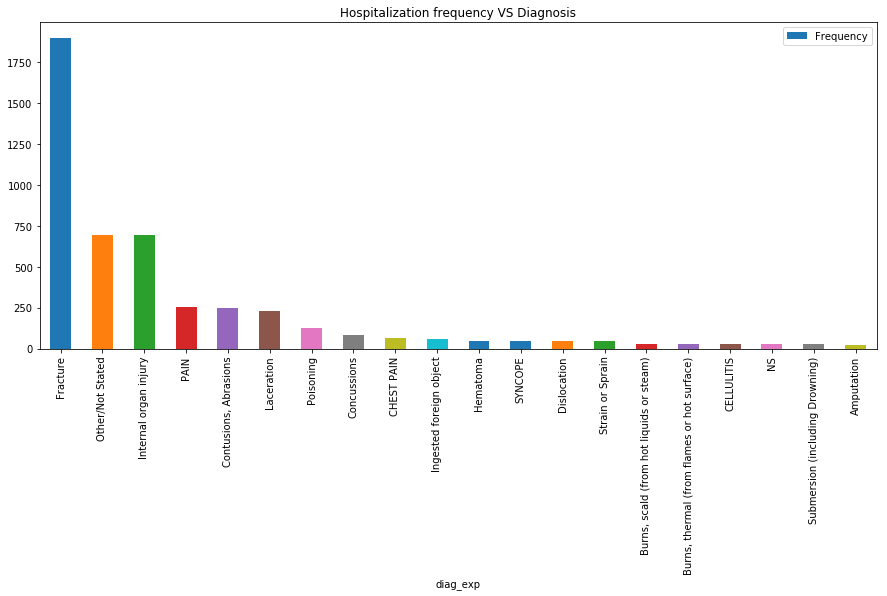

In [10]:
# Creating visualisation for required analysis
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)
plt.figure()
concat_hospitalized.iloc[0:20].plot(x='diag_exp', y='Frequency', kind='bar', title="Hospitalization frequency VS Diagnosis");

## Step 2 Answer: Fracture (diag code 57) has highest number of hospitalization

## Step 3: Disposition code 6 is for left without seen

In [11]:
# Repeating same steps for code 6
total_unseen = merged_df[(merged_df["disposition"]==6)].shape[0]
diag_unseen = merged_df[(merged_df["disposition"]==6)]["diag"].value_counts()\
                    .to_frame().reset_index().rename(columns={'index': 'diag', 'diag': 'Frequency'})\
                    .sort_values(by=['Frequency'], ascending=False)
diag_unseen = pd.merge(left=diag_unseen, right=diagnosis_df, how='left', on='diag')
diag_other_unseen = merged_df[(merged_df["disposition"]==6)]["diag_other"] \
                        .value_counts()\
                        .to_frame().reset_index().rename(columns={'index': 'diag_exp', 'diag_other': 'Frequency'})\
                        .sort_values(by=['Frequency'], ascending=False)
concat_unseen = pd.concat([diag_unseen.drop(['diag'], axis=1), diag_other_unseen], ignore_index = True)\
                        .sort_values(by=['Frequency'], ascending=False)

Populating the interactive namespace from numpy and matplotlib


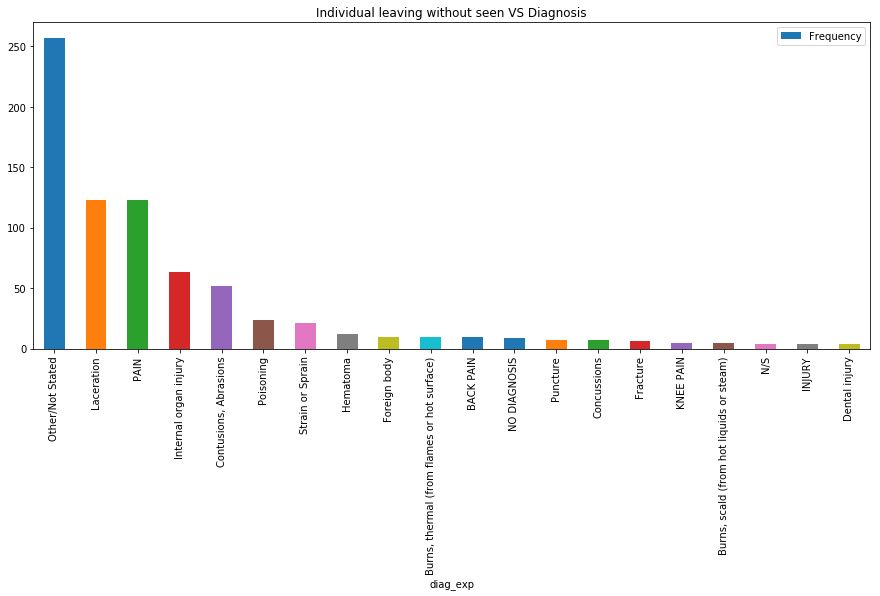

In [12]:
# Creating visualisation for required analysis
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 6)
plt.figure()
concat_unseen.iloc[0:20].plot(x='diag_exp', y='Frequency', kind='bar', title="Individual leaving without seen VS Diagnosis");

## Step 3 Answer: Most of diagnosis of unseen is Other/Not Stated(diag code 71)

## Step 4: Discussion

In [13]:
total_unrecorded = merged_df[(merged_df["disposition"]==9)].shape[0]
print("Total Disposition Not Recorded incidents:", total_unrecorded)

Total Disposition Not Recorded incidents: 0


In [17]:
# Preparing data for plotting histograms as required in plotly
diag_freq = merged_df["diag"].value_counts().to_frame().reset_index().rename(columns={'index': 'diag', 'diag': 'Frequency'})
df = merged_df
data = []
buttons = []

demo = df.groupby(['disposition'])[df.columns[0]].count().to_frame().reset_index().rename(columns={'CPSC Case #': 'Frequency'})
trace = go.Bar(x=demo['disposition'], y=demo.Frequency)
data.append(trace)
label = 'All'
method = 'update'
visible = [False]*(diag_freq.shape[0] + 1)
visible[0] = True
args = [{'visible': visible}, {'title': 'Distribution of all diagnosis' + ' across dispositions'}]
buttons.append(dict(label= label, method=method, args=args))

for i in range(diag_freq.shape[0]):
    diag = diag_freq.iloc[i].diag
    diag_exp = diagnosis_df[diagnosis_df["diag"] == diag]["diag_exp"].item()[:20]
    demo = df[df.diag == diag].groupby(['disposition'])[df.columns[0]].count().to_frame().reset_index().rename(columns={'CPSC Case #': 'Frequency'})
    trace = go.Bar(x=demo['disposition'], y=demo.Frequency)
    data.append(trace)
    label = diag_exp
    method = 'update'
    visible = [False]*(diag_freq.shape[0] + 1)
    visible[i+1] = True
    args = [{'visible': visible}, {'title': 'Distribution of ' + diag_exp + ' across dispositions'}]
    buttons.append(dict(label= label, method=method, args=args))

# Preparing inputs for dashboard
updatemenus = list([
    dict(active=0,
         buttons=list(buttons),
    )
])

layout = dict(title='Frequency distribution for diagnosis across dispositions.', showlegend=False, updatemenus=updatemenus, margin=go.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

fig = dict(data=data, layout=layout)

In [18]:
# Plot the dashboard
py.offline.iplot(fig, filename='update_dropdown')

In [27]:
# Preparing data for plotting histograms as required in plotly
disp_freq = merged_df["disposition"].value_counts().to_frame().reset_index().rename(columns={'index': 'disp', 'disposition': 'Frequency'})
df = merged_df
data = []
buttons = []

demo = df.groupby(['diag'])[df.columns[0]].count().to_frame().reset_index().rename(columns={'CPSC Case #': 'Frequency'})
trace = go.Bar(x=demo['diag'], y=demo.Frequency)
data.append(trace)
label = 'All'
method = 'update'
visible = [False]*(diag_freq.shape[0] + 1)
visible[0] = True
args = [{'visible': visible}, {'title': 'Distribution of all dispositions' + ' across diagnosis'}]
buttons.append(dict(label= label, method=method, args=args))

for i in range(disp_freq.shape[0]):
    disp = disp_freq.iloc[i].disp
    disp_exp = disposition_df[disposition_df["disposition"] == disp]["disposition_exp"].item()[:20]
    demo = df[df.disposition == disp].groupby(['diag'])[df.columns[0]].count().to_frame().reset_index().rename(columns={'CPSC Case #': 'Frequency'})
    trace = go.Bar(x=demo['diag'], y=demo.Frequency)
    data.append(trace)
    label = disp_exp
    method = 'update'
    visible = [False]*(diag_freq.shape[0] + 1)
    visible[i+1] = True
    args = [{'visible': visible}, {'title': 'Distribution of ' + disp_exp + ' across diagnosis'}]
    buttons.append(dict(label= label, method=method, args=args))

# Preparing inputs for dashboard
updatemenus = list([
    dict(active=0,
         buttons=list(buttons),
    )
])

layout = dict(title='Frequency distribution for disposition across diagnosis.', showlegend=False, updatemenus=updatemenus, margin=go.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

fig = dict(data=data, layout=layout)

In [28]:
# Plot the dashboard
py.offline.iplot(fig, filename='update_dropdown_2')

For most of the deaths, the reason is Other/Not Stated. Internal organ injury(code 62) is the second largest reason for deaths.
Most of the time the diagnois is not stated if patient leaves without seeing.

In [30]:
# Creating contingency table
contingency_table = pd.pivot_table(merged_df, values=["CPSC Case #"], index=["disposition"], columns=["diag"], aggfunc=lambda x: len(x.unique())).fillna(value=0)
# Calculating chi square and p-value
chi2, p, dof, _ = chi2_contingency(contingency_table.values)

In [33]:
print("Chi square, significance level and degrees of freedom are", chi2, "," , p, "and", dof, "respectively")

Chi square, significance level and degrees of freedom are 7179.962553169011 , 0.0 and 145 respectively
